In [2]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load csvs from data-analysis folder

spend_revenue = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data-analysis/spend_revenue.csv")
sales_full_merged = pd.read_csv(r"/Users/adityamxr/Desktop/finding-marketing-insights/data-analysis/sales_full_merged.csv")

In [4]:
# verify import

dfs = [spend_revenue, sales_full_merged]

for df in dfs:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearMonth                   12 non-null     object 
 1   Total_Revenue               12 non-null     float64
 2   Offline_Spend               12 non-null     int64  
 3   Online_Spend                12 non-null     float64
 4   Total_Spend                 12 non-null     float64
 5   Marketing_Spend_Percentage  12 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 708.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            52924 non-null  int64  
 1   Transaction_ID        52924 non-null  int64  
 2   Transaction_Date      52924 non-null  object 
 3   P

In [6]:
# transaction_date is in str format - convert to datetime
sales_full_merged['Transaction_Date'] = pd.to_datetime(sales_full_merged['Transaction_Date'])

In [7]:
# define the latest purchase date (the most recent transaction in the dataset)
latest_purchase_date = sales_full_merged['Transaction_Date'].max()

# recency, Frequency, and Monetary value calculations
recency = sales_full_merged.groupby('CustomerID').agg({'Transaction_Date': lambda x: (latest_purchase_date - x.max()).days}).reset_index().rename(columns={'Transaction_Date': 'Recency'})
frequency = sales_full_merged.groupby('CustomerID').agg({'Transaction_ID': 'nunique'}).reset_index().rename(columns={'Transaction_ID': 'Frequency'})
monetary = sales_full_merged.groupby('CustomerID').agg({'Invoice_Value': 'sum'}).reset_index().rename(columns={'Invoice_Value': 'Monetary'})

# combine into RFM dataframe
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

In [8]:
# create RFM Score based on quantiles (1 to 4 for each R, F, M)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# calculate RFM score by summing individual scores
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# define segments based on RFM score thresholds
rfm['Segment'] = pd.cut(rfm['RFM_Score'], bins=[0, 3, 6, 9, 12], labels=['Standard', 'Silver', 'Gold', 'Premium'])

# define Strategy for each segment
segment_strategy = {
    'Premium': "Focus on maintaining a strong relationship through personalized offers and premium services.",
    'Gold': "Engage more with targeted offers and loyalty programs to encourage repeat purchases.",
    'Silver': "Provide incentives like discounts or free shipping to move them to Gold or Premium.",
    'Standard': "Use broad campaigns and introductory offers to increase engagement and convert them to higher segments."
}

# map strategies to RFM segments
rfm['Strategy'] = rfm['Segment'].map(segment_strategy)

# verify
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Strategy
0,12346,107,1,171.725887,3,1,1,5,Silver,Provide incentives like discounts or free ship...
1,12347,59,31,10632.890268,3,4,4,11,Premium,Focus on maintaining a strong relationship thr...
2,12348,73,8,1341.274742,3,2,2,7,Gold,Engage more with targeted offers and loyalty p...
3,12350,17,11,1080.966849,4,2,2,8,Gold,Engage more with targeted offers and loyalty p...
4,12356,107,13,1648.281319,3,3,3,9,Gold,Engage more with targeted offers and loyalty p...


### RFM Segmentation was successfully done - visualize RFM segments now

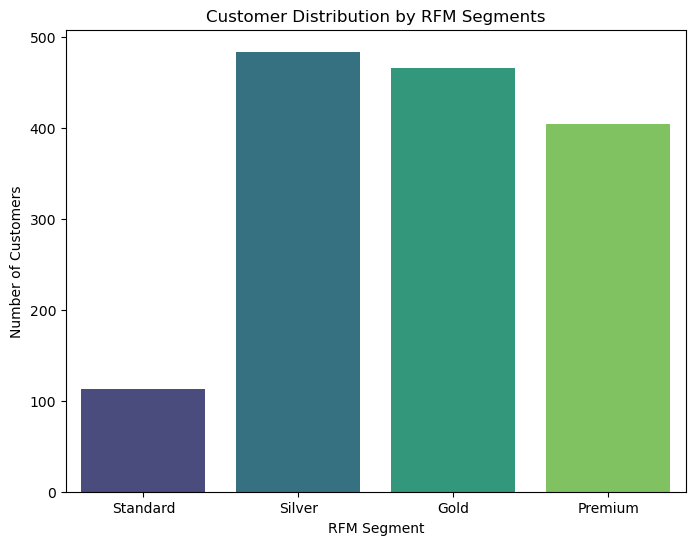

In [9]:
# visualize RFM segments

# number of customers in each segment
segment_counts = rfm['Segment'].value_counts()

# bar Plot of RFM Segments
plt.figure(figsize=(8,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Distribution by RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()

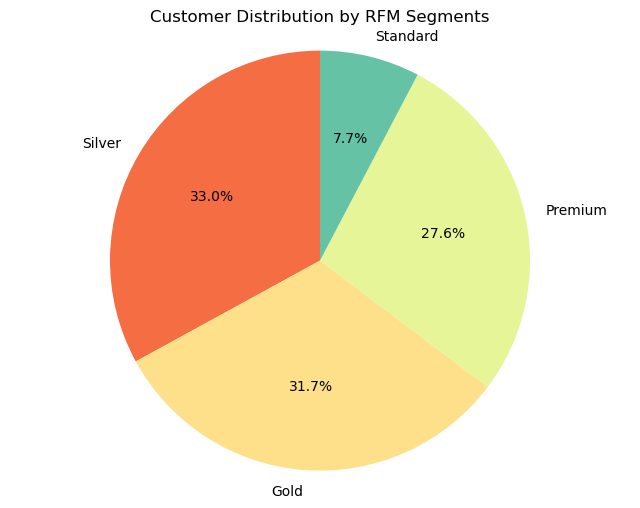

In [10]:
# pie Chart of RFM Segments
plt.figure(figsize=(8,6))
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Spectral', len(segment_counts)))
plt.axis('equal') # aspect ratio
plt.title('Customer Distribution by RFM Segments')
plt.show()